# Geopandas and Shapely binary predicates

Geopandas [spatial joins](https://geopandas.org/gallery/spatial_joins.html#Spatial-Joins) use Shapely's [binary predicates](https://shapely.readthedocs.io/en/latest/manual.html#binary-predicates), but I often find it difficult to know which one to use.

This is a visual explainer to show how the different predicates work. It didn't fully demystify the predicates, but it helped me understand them better.

One important thing that I learned in making this reference is that multi-polygon or multi-linestring features can confound the behavior of some of these predicates. If you're getting unexpected results, consider converting your multi-geometries to having multiple rows for each piece of the geometry.

## Other methods demonstrated in this notebook

This notebook downloads some spatial data and does some manipulations of spatial data to help demonstrate the spatial predicates. In addition to that core concept, this notebook is also an example of:

- Using the [tqdm](https://github.com/tqdm/tqdm) package, along with the [requests](https://docs.python-requests.org/en/latest/) package to show a progress bar while downloading a file. This also conditionally downloads the file only if it hasn't already been downloaded.
- Using matplotlib via [`GeoDataFrame.plot()`](https://geopandas.org/docs/reference/api/geopandas.GeoDataFrame.plot.html) to [map multiple layers](https://geopandas.org/docs/user_guide/mapping.html#maps-with-layers)
- Getting the border of a polygon feature as a line feature using [`GeoSeries.exterior`](https://geopandas.readthedocs.io/en/latest/docs/reference/api/geopandas.GeoSeries.exterior.html)
- Breaking a multipolygon into separate polygons using [`GeoDataFrame.explode()`](https://geopandas.org/docs/reference/api/geopandas.GeoDataFrame.explode.html)

## Shapely's spatial data model

The way these predicates work really didn't make sense to me until I carefully read [Shapely's spatial data model](https://shapely.readthedocs.io/en/latest/manual.html#spatial-data-model) to understand what the documentation means when they talk about *dimension*.

Here are the parts I found most relevant:

> The fundamental types of geometric objects implemented by Shapely are points, curves, and surfaces. Each is associated with three sets of (possibly infinite) points in the plane. The interior, boundary, and exterior sets of a feature are mutually exclusive and their union coincides with the entire plane 2.
> - A Point has an interior set of exactly one point, a boundary set of exactly no points, and an exterior set of all other points. A Point has a topological dimension of 0.
> - A Curve has an interior set consisting of the infinitely many points along its length (imagine a Point dragged in space), a boundary set consisting of its two end points, and an exterior set of all other points. A Curve has a topological dimension of 1.
> - A Surface has an interior set consisting of the infinitely many points within (imagine a Curve dragged in space to cover an area), a boundary set consisting of one or more Curves, and an exterior set of all other points including those within holes that might exist in the surface. A Surface has a topological dimension of 2.
>
> ...
>
> The point type is implemented by a Point class; curve by the LineString and LinearRing classes; and surface by a Polygon class. Shapely implements no smooth (i.e. having continuous tangents) curves. All curves must be approximated by linear splines. All rounded patches must be approximated by regions bounded by linear splines.

In [1]:
# Setup

import logging
from pathlib import Path
from urllib.parse import urlparse

from IPython.display import Markdown, display
import geopandas as gpd
import requests
#from tqdm import tqdm
from tqdm.notebook import tqdm

# Local settings module
# I use this to build paths to data files.
# See project_settings_module.ipynb for more on this method.
import settings

# Make sure we show info level log messages.
# This is the level used to report when we skip downloading a file because it
# already exists.
logging.basicConfig(level=logging.INFO)

In [2]:
# Define a function that wraps downloading functionality

def download(url, output_dir, filename=None, skip_if_exists=True):
    """
    Download a file from a URL and save in a local directory
    
    Returns the path to the downloaded file
    
    This is based on the snippet in
    https://stackoverflow.com/questions/37573483/progress-bar-while-download-file-over-http-with-requests
    
    """
    if filename is None:
        filename = urlparse(url).path.split("/")[-1]
        
    output_path = Path(output_dir) / filename
    
    # Decide if we're actually going to download the file
    do_download = (
        # If `skip_if_exists` is False, we should download
        (not skip_if_exists)
        # If the file doesn't exist, we should download 
        or (not output_path.exists())
    )
    
    if not do_download:
        if output_path.exists():
            logging.info("Skipping download because `%s` already exists", output_path)
            
        # If not downloading the file, return early
        return output_path
    
    resp = requests.get(url, stream=True, allow_redirects=True)
    
    if resp.status_code != 200:
        resp.raise_for_status()
        
    # TODO: Decide if this should default to zero or raise an exception
    file_size = int(resp.headers.get("Content-Length", 0))
    
    block_size = 1024 # 1024 bytes in one KB
    
    # This seems cleaner, but it doesn't get the units right
    #progress_bar = tqdm(resp.iter_content(block_size), total=file_size // block_size, unit="iB", unit_scale=True)
    # So, instead of doing `for data in progress_bar`, we'll iterate
    # through `resp.iter_content(block_size) and manually update the bar.
    progress_bar = tqdm(total=file_size, unit="iB", unit_scale=True)
    
    with open(output_path, "wb") as outf:
        for data in resp.iter_content(block_size):
            progress_bar.update(len(data))
            outf.write(data)
    
    progress_bar.close()
    
    return output_path

## Data sources

- County boundaries, 2021 ([U.S. Census Bureau](https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html))

In [3]:
# Download county boundaries
# See https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html

counties_shapefile_url = "https://www2.census.gov/geo/tiger/TIGER2021/COUNTY/tl_2021_us_county.zip"

counties_shapefile_path = download(counties_shapefile_url, settings.DATA_DIR_SRC, skip_if_exists=True)

display(Markdown(f"Downloaded county shapefile to `{counties_shapefile_path}`"))

INFO:root:Skipping download because `/Users/GHing/workspace/python-data-cheatsheet/data/source/tl_2021_us_county.zip` already exists


Downloaded county shapefile to `/Users/GHing/workspace/python-data-cheatsheet/data/source/tl_2021_us_county.zip`

<AxesSubplot:>

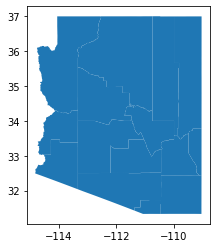

In [4]:
# Load county boundaries
counties = gpd.read_file(counties_shapefile_path)

# Get only Arizona counties
counties_az = counties[counties["STATEFP"] == "04"].copy()

counties_az.plot()

- American Indian/Alaska Native/Native Hawaiian Area boundaries, 2021 ([U.S. Census Bureau](https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html))

In [5]:
# Download tribal areas
# See https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html

tribal_areas_url = "https://www2.census.gov/geo/tiger/TIGER2021/AIANNH/tl_2021_us_aiannh.zip"

tribal_areas_path = download(tribal_areas_url, settings.DATA_DIR_SRC, skip_if_exists=True)


INFO:root:Skipping download because `/Users/GHing/workspace/python-data-cheatsheet/data/source/tl_2021_us_aiannh.zip` already exists


In [6]:
# Load tribal areas

tribal_areas = gpd.read_file(tribal_areas_path)

In [7]:
# Get a dataframe of just the boundary of the Navajo Nation

navajo_nation = tribal_areas[tribal_areas["NAMELSAD"] == "Navajo Nation Reservation"].copy()

navajo_nation

,AIANNHCE,AIANNHNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,COMPTYP,AIANNHR,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
117,2430,00041148,2430R,Navajo Nation,Navajo Nation Reservation,86,D8,R,F,G2101,A,58370582767,59949501,+36.2013734,-109.9049064,"MULTIPOLYGON (((-107.20370 35.02868, -107.2036..."


- Arizona Places, 2021 ([U.S. Census Bureau](https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html))

In [8]:
# Download Arizona Census places

places_az_url = "https://www2.census.gov/geo/tiger/TIGER2021/PLACE/tl_2021_04_place.zip"

places_az_path = download(places_az_url, settings.DATA_DIR_SRC, skip_if_exists=True)

INFO:root:Skipping download because `/Users/GHing/workspace/python-data-cheatsheet/data/source/tl_2021_04_place.zip` already exists


In [9]:
# Load Arizona places

places_az = gpd.read_file(places_az_path)

## Example: Arizona counties and the Navajo Nation

<AxesSubplot:>

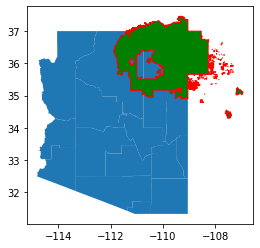

In [10]:
# Show Arizona counties and the Navajo Nation
# See https://geopandas.org/docs/user_guide/mapping.html#maps-with-layers
# for the documentation on showing multiple layers using matplotlib

counties_map = counties_az.plot()

navajo_nation.plot(ax=counties_map, edgecolor="red", color="green")

### Intersects

The Navajo Nation intersects Coconino, Navajo and Apache County

In [11]:
# Get DataFrame of counties that the Navajo Nation intersects
navajo_nation.sjoin(
    counties_az,
    how="inner",
    predicate="intersects"
)[["NAME_right"]]

,NAME_right
117,Coconino
117,Navajo
117,Apache


## Crosses

The polygon version of the Navajo nation's boundary doesn't cross the polygon version of any county boundary, in terms of how the predicates work. That's because while "the interior of the object intersects the interior of the other but does not contain it", the "dimension of the intersection" is **not** "less than the dimension of the one or the other."

The intersection of the interiors of two polygons is a surface, the same as the two layers.

In [12]:
# Get DataFrame of counties that the Navajo Nation crosses, using polygon
# layers

navajo_nation.sjoin(
    counties_az,
    how="inner",
    predicate="crosses"
)[["NAME_right"]]

,NAME_right


In [13]:
# Get DataFrame of counties that cross the Navajo Nation, using polygon
# layers

counties_az.sjoin(
    navajo_nation,
    how="inner",
    predicate="crosses"
)[["NAME_right"]]

,NAME_right


If we convert the county polygons to a line, we can see that the county boundary lines cross the Navajo Nation polygon.

In [14]:
# See if the border of Arizona counties, as a line, crosses the Navajo Nation
# polygon

counties_az_as_line = counties_az.copy()
counties_az_as_line["geometry"] = counties_az_as_line["geometry"].exterior

counties_az_as_line.sjoin(
    navajo_nation,
    how="inner",
    predicate="crosses"
)[["NAME_left"]]

,NAME_left
522,Navajo
1311,Coconino
2590,Apache


Strangely, the inverse isn't the case.

In [15]:
# See if the border of the Navajo Nation, as a line, crosses Arizona county
# polygons.

navajo_nation_as_line = navajo_nation.copy()
navajo_nation_as_line["geometry"] = navajo_nation_as_line["geometry"].exterior

navajo_nation_as_line.sjoin(
    counties_az,
    how="inner",
    predicate="crosses"
)[["NAME_right"]]

,NAME_right


I suspect this is because of some of the non-contiguous parts of the Navajo Nation. I tried breaking up the Navajo Nation multipolygon into separate polygons using `GeoDataFrame.explode()` and picking just the largest one and converting its boundary to a line.

/var/folders/fz/3z_c5s9s3h73qptb_c8c57m00000gp/T/ipykernel_47393/21469080.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  navajo_nation_largest_area = navajo_nation_parts[navajo_nation_parts["geometry"].area == navajo_nation_parts["geometry"].area.max()]


<AxesSubplot:>

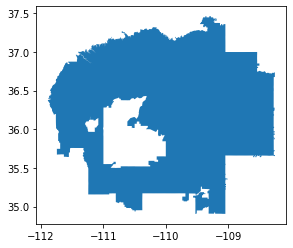

In [16]:
# Get just the large, contiguous portion of the Navajo Nation as both a
# polygon and a line.

navajo_nation_parts = navajo_nation.explode(index_parts=True)

# This will show a warning about the projection causing inaccurate area,
# but we just care about the relative area, so I think we're ok.
navajo_nation_largest_area = navajo_nation_parts[navajo_nation_parts["geometry"].area == navajo_nation_parts["geometry"].area.max()]

navajo_nation_largest_area_as_line = navajo_nation_largest_area.copy()
navajo_nation_largest_area_as_line["geometry"] = navajo_nation_largest_area_as_line["geometry"].exterior

navajo_nation_largest_area.plot()

Using the outline of the large, contiguous portion of the Navajo Nation, we can see it crosses the county polygons.

In [17]:
navajo_nation_largest_area_as_line.sjoin(
    counties_az,
    how="inner",
    predicate="crosses"
)[["NAME_right"]]

NAME_right
117 310   Coconino
    310     Navajo
    310     Apache

The line versions of the large, contiguous area of the Navajo Nation and the counties don't cross based on the predicate criteria.

In [18]:
counties_az_as_line.sjoin(
    navajo_nation_largest_area_as_line,
    how="inner",
    predicate="crosses"
)[["NAME_left"]]

,NAME_left


In [19]:
navajo_nation_largest_area_as_line.sjoin(
    counties_az_as_line,
    how="inner",
    predicate="crosses"
)[["NAME_left"]]

,,NAME_left


I think this is because the intersection of the line features end up being lines themselves. That is, they aren't a lower dimension.

In [20]:
# Show the geometry type of the intersection of county border lines with
# the line of the Navajo Nation border.

counties_az_as_line.overlay(
    navajo_nation_largest_area_as_line,
    how="intersection"
)["geometry"].type.unique()

/Users/GHing/.local/share/virtualenvs/python-data-cheatsheet-ujiHmgN_/lib/python3.9/site-packages/geopandas/geodataframe.py:2196: UserWarning: `keep_geom_type=True` in overlay resulted in 251 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  return geopandas.overlay(


array(['MultiLineString'], dtype=object)

### Overlaps

Both the polygon and line version of the Navajo Nation boundaries overlap with counties

In [21]:
# Show that the polygons for the Navajo Nation and counties don't touch as far
# as the predicate is concerned.

navajo_nation.sjoin(
    counties_az,
    how="inner",
    predicate="overlaps"
)[["NAME_right"]]

,NAME_right
117,Coconino
117,Navajo
117,Apache


In [22]:
# Show that the polygons for the Navajo Nation and counties don't touch as far
# as the predicate is concerned.

navajo_nation_largest_area_as_line.sjoin(
    counties_az_as_line,
    how="inner",
    predicate="overlaps"
)[["NAME_left"]]

NAME_left
117 310  Navajo Nation
    310  Navajo Nation
    310  Navajo Nation

### Touches

The polygons for the Navajo Nation and counties don't touch, because their interiors also intersect.

In [23]:
# Show that the polygons for the Navajo Nation and counties don't touch as far
# as the predicate is concerned.

navajo_nation.sjoin(
    counties_az,
    how="inner",
    predicate="touches"
)[["NAME_right"]]

,NAME_right


## Example: Maricopa County

In [24]:
# Get a Data Frame of just Maricopa County and all other counties

maricopa_county = counties_az[counties_az["NAME"] == "Maricopa"].copy()
counties_az_except_maricopa = counties_az[counties_az["NAME"] != "Maricopa"].copy()

<AxesSubplot:>

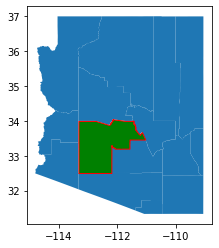

In [25]:
# Plot Maricopa and its neighbors as a map

not_maricopa_map = counties_az_except_maricopa.plot()

maricopa_county.plot(ax=not_maricopa_map, edgecolor="red", color="green")

### Intersects

Maricopa intersects with the neighboring counties because they share borders.

In [26]:
# Show county polygons that Maricopa's polygon intersects with

maricopa_county.sjoin(
    counties_az_except_maricopa,
    how="inner",
    predicate="intersects"
)["NAME_right"]

851       Yuma
851     La Paz
851    Yavapai
851       Pima
851      Pinal
851       Gila
Name: NAME_right, dtype: object

### Touches

That is, the polygons for Maricopa touch the polygons for the neighboring counties

In [27]:
# Show county polygons that Maricopa's polygon touches

maricopa_county.sjoin(
    counties_az_except_maricopa,
    how="inner",
    predicate="touches"
)["NAME_right"]

851       Yuma
851     La Paz
851    Yavapai
851       Pima
851      Pinal
851       Gila
Name: NAME_right, dtype: object

### Overlaps

But Maricopa County's polygon won't overlap ...

In [28]:
# Show county polygons that Maricopa's polygon overlaps

maricopa_county.sjoin(
    counties_az_except_maricopa,
    how="inner",
    predicate="overlaps"
)["NAME_right"]

Series([], Name: NAME_right, dtype: object)

### Crosses

... or cross the boundaries of neighboring counties.

In [29]:
# Show county polygons that Maricopa's polygon crosses

maricopa_county.sjoin(
    counties_az_except_maricopa,
    how="inner",
    predicate="crosses"
)["NAME_right"]

Series([], Name: NAME_right, dtype: object)

## Example: Phoenix

In [30]:
# Get a DataFrame of just Phoenix's polygon

phoenix = places_az[places_az["NAME"] == "Phoenix"]

In [31]:
# Get Phoenix's border as a line

phoenix_as_line = phoenix.copy()
phoenix_as_line["geometry"] = phoenix_as_line["geometry"].exterior

<AxesSubplot:>

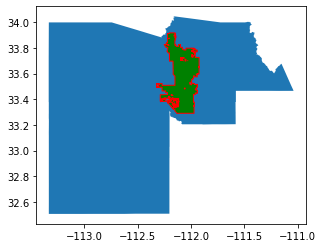

In [32]:
# Plot Phoenix and Maricopa county

maricopa_map = maricopa_county.plot()

phoenix.plot(ax=maricopa_map, edgecolor="red", color="green")

### Intersects

Phoenix's polygon intersects with that of Maricopa county.

In [33]:
# Show that Phoenix's polygon intersects with that of Maricopa county

phoenix.sjoin(
    maricopa_county,
    how="inner",
    predicate="intersects"
)["NAME_right"]

53    Maricopa
Name: NAME_right, dtype: object

### Overlaps

Phoenix's polygon does not overlap with that of Maricopa county. I think this is because all of Phoenix's points are within Maricopa County's polygon.

In [34]:
# Show that Phoenix's polygon does not overlap with that of Maricopa county

phoenix.sjoin(
    maricopa_county,
    how="inner",
    predicate="overlaps"
)["NAME_right"]

Series([], Name: NAME_right, dtype: object)

### Touches

Phoenix's polygon does not touch that of Maricopa county because it is wholly within the county boundary.

In [35]:
# Show that Phoenix's polygon does not touch that of Maricopa county

phoenix.sjoin(
    maricopa_county,
    how="inner",
    predicate="touches"
)["NAME_right"]

Series([], Name: NAME_right, dtype: object)

### Contains

Maricopa County's polygon contains that of Phoenix.

In [36]:
# Show that Maricopa County's polygon contains that of Phoenix

maricopa_county.sjoin(
    phoenix,
    how="inner",
    predicate="contains"
)["NAME_right"]

851    Phoenix
Name: NAME_right, dtype: object

But it doesn't contain the line of Phoenix's border. You can read more about this counterintuitive behavior in [Quirks of the "Contains" Spatial Predicate](https://lin-ear-th-inking.blogspot.com/2007/06/subtleties-of-ogc-covers-spatial.html).

In [37]:
# Show that Maricopa County's polygon doesn't contain the line of the border of the city.

maricopa_county.sjoin(
    phoenix_as_line,
    how="inner",
    predicate="contains"
)["NAME_right"]

Series([], Name: NAME_right, dtype: object)

### Covers

Maricopa County's polygon covers that of Phoenix.

In [38]:
# Show that Maricopa County's polygon covers that of Phoenix

maricopa_county.sjoin(
    phoenix,
    how="inner",
    predicate="covers"
)["NAME_right"]

851    Phoenix
Name: NAME_right, dtype: object

And it should also cover the line of Phoenix's border, according to [Quirks of the "Contains" Spatial Predicate](https://lin-ear-th-inking.blogspot.com/2007/06/subtleties-of-ogc-covers-spatial.html).

However it doesn't.

In [39]:
maricopa_county.sjoin(
    phoenix_as_line,
    how="inner",
    predicate="covers"
)["NAME_right"]

Series([], Name: NAME_right, dtype: object)

I think this is because there are actually multiple polygons that compose Phoenix's area.

In [40]:
# Break the multiply polygons of Phoenix into separate rows

phoenix_pieces = phoenix.explode(index_parts=True)

phoenix_pieces

STATEFP PLACEFP   PLACENS    GEOID     NAME      NAMELSAD LSAD CLASSFP  \
53 0      04   55000  02411414  0455000  Phoenix  Phoenix city   25      C1   
   1      04   55000  02411414  0455000  Phoenix  Phoenix city   25      C1   

     PCICBSA PCINECTA  MTFCC FUNCSTAT       ALAND   AWATER     INTPTLAT  \
53 0       Y        N  G4110        A  1342303901  2633970  +33.5721544   
   1       Y        N  G4110        A  1342303901  2633970  +33.5721544   

          INTPTLON                                           geometry  
53 0  -112.0901324  POLYGON ((-112.12626 33.36182, -112.12550 33.3...  
   1  -112.0901324  POLYGON ((-112.32407 33.51469, -112.32394 33.5...

In [41]:
# Get only the largest polygon for Phoenix and also get its border as a line

phoenix_largest_piece = phoenix_pieces[phoenix_pieces.area == phoenix_pieces.area.max()]

phoenix_largest_piece_as_line = phoenix_largest_piece.copy()
phoenix_largest_piece_as_line["geometry"] = phoenix_largest_piece_as_line["geometry"].exterior

/var/folders/fz/3z_c5s9s3h73qptb_c8c57m00000gp/T/ipykernel_47393/1553427259.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  phoenix_largest_piece = phoenix_pieces[phoenix_pieces.area == phoenix_pieces.area.max()]


In [42]:
# Show that Maricopa County's polygon covers one of the lines representing
# the border for the largest part of Phoenix.

maricopa_county.sjoin(
    phoenix_largest_piece_as_line,
    how="inner",
    predicate="covers"
)["NAME_right"]

851    Phoenix
Name: NAME_right, dtype: object

### Within

Phoenix's polygon is within that of Maricopa County.

In [43]:
# Show that Phoenix's polygon is within that of Maricopa County

phoenix.sjoin(
    maricopa_county,
    how="inner",
    predicate="within"
)["NAME_right"]

53    Maricopa
Name: NAME_right, dtype: object

And Phoenix is within itself, though that doesn't make sense to me based on the definition of the Shapely predicate:

> Returns True if the object’s boundary and interior intersect only with the interior of the other (not its boundary or exterior).

This may have to do with the way that GeoPandas [uses `contains` to implement `within` as an optimization](https://github.com/geopandas/geopandas/blob/master/geopandas/sindex.py#L481).

In [44]:
# Show that Phoenix's polygon is (confusingly) in itself

phoenix.sjoin(
    phoenix,
    how="inner",
    predicate="within"
)["NAME_right"]

53    Phoenix
Name: NAME_right, dtype: object

## Example: Queen Creek

In [45]:
# Get a DataFrame containing only the polygon for Queen Creek

queen_creek = places_az[places_az["NAME"] == "Queen Creek"]

<AxesSubplot:>

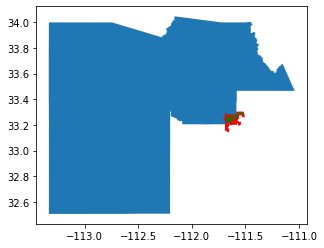

In [46]:
# Plot Queen Creek and Maricopa county

maricopa_map = maricopa_county.plot()

queen_creek.plot(ax=maricopa_map, edgecolor="red", color="green")

### Intersects

Queen Creek intersects with Maricopa County.

In [47]:
# Show that Queek Creek's polygon intersects with that of Maricopa County.

queen_creek.sjoin(
    maricopa_county,
    how="inner",
    predicate="intersects"
)["NAME_right"]

50    Maricopa
Name: NAME_right, dtype: object

### Overlaps

And also overlaps with the county.

In [48]:
# Show that Queek Creek's polygon overlaps with that of Maricopa County.

queen_creek.sjoin(
    maricopa_county,
    how="inner",
    predicate="overlaps"
)["NAME_right"]

50    Maricopa
Name: NAME_right, dtype: object

### Contains

Maricopa County doesn't contain Queen Creek.

In [49]:
# Show that Maricopa County's polygon doesn't contain that of Queen Creek.

maricopa_county.sjoin(
    queen_creek,
    how="inner",
    predicate="contains"
)["NAME_right"]

Series([], Name: NAME_right, dtype: object)

### Within

And Queen Creek isn't within Maricopa County.

In [50]:
# Show that Queen Creek's polygon isn't within that of Maricopa County

queen_creek.sjoin(
    maricopa_county,
    how="inner",
    predicate="within"
)["NAME_right"]

Series([], Name: NAME_right, dtype: object)